In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer, Custom Generator
Do the same model as 03 but with the custom data generator.  Set the injection rate to 0 to simulate the "raw" case.  This is done as a smoke test to make sure the data generator doesn't change any outcomes.

Custom data generators are used to retrieve data at each batch or epoch, and can be used to modify data for every batch or epoch.  In future scripts, I modify at the batch level, injecting random "1" values.  Here I just use the generator but with 0 injection rate as a test case.  See also  https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/utils/Sequence

Encode only the base NAICS.

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [10]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature - just bas
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [12]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [13]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 11), y:(446848,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 11), y:(95604,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

In [17]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-19 12:50:25.681934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-19 12:50:25.681956: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-19 12:50:25.681960: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-19 12:50:25.681987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 12:50:25.682000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 emb_naics_00 (Embedding)    (None, 1, 8)                 9360      ['input_naics_00[0][0]']      
                                                                                                  
 NAICS (Flatten)             (None, 8)                    0         ['emb_naics_00[0][0]']        
                                                                                                  
 input_numeric (InputLayer)  [(None, 10)]                 0         []                        

##### Use data generator to inject 1 values into training data

In [19]:
importlib.reload(sbnn_model)
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator 

In [20]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0,
                               injection_value = 1)

In [21]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [22]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric], X_val[features_naics]], y_val),
                              shuffle=True,
                             callbacks=[callback])

Epoch 1/20


2024-05-19 12:50:26.152745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4629 - auc: 0.3357 - auc_1: 0.6987

2024-05-19 12:52:31.098600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 142s 10ms/step - loss: 0.4629 - auc: 0.3357 - auc_1: 0.6987 - val_loss: 0.4550 - val_auc: 0.3684 - val_auc_1: 0.7208
Epoch 2/20
13964/13964 [==============================] - 151s 11ms/step - loss: 0.4551 - auc: 0.3563 - auc_1: 0.7155 - val_loss: 0.4522 - val_auc: 0.3757 - val_auc_1: 0.7258
Epoch 3/20
13964/13964 [==============================] - 170s 12ms/step - loss: 0.4530 - auc: 0.3640 - auc_1: 0.7196 - val_loss: 0.4514 - val_auc: 0.3813 - val_auc_1: 0.7279
Epoch 4/20
13964/13964 [==============================] - 183s 13ms/step - loss: 0.4516 - auc: 0.3693 - auc_1: 0.7227 - val_loss: 0.4539 - val_auc: 0.3829 - val_auc_1: 0.7294
Epoch 5/20
13964/13964 [==============================] - 188s 13ms/step - loss: 0.4505 - auc: 0.3727 - auc_1: 0.7249 - val_loss: 0.4511 - val_auc: 0.3837 - val_auc_1: 0.7299
Epoch 6/20
13964/13964 [==============================] - 190s 14ms/step - loss: 0.4499 - auc: 0.3740 - auc_1: 0.7261 - val_loss: 0.4499

In [23]:
this_history_df = sbnn_model.process_history(this_history)

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('10_REPORT_fit_history.csv'))

<Axes: >

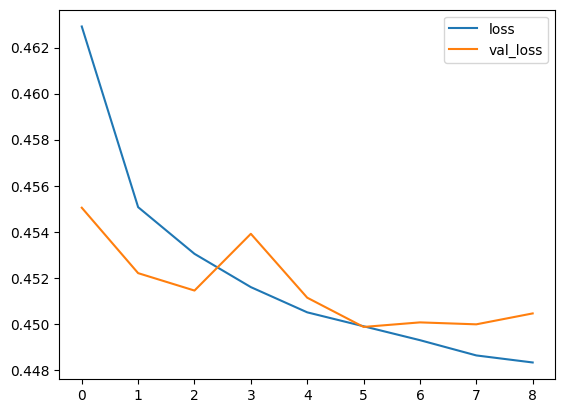

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

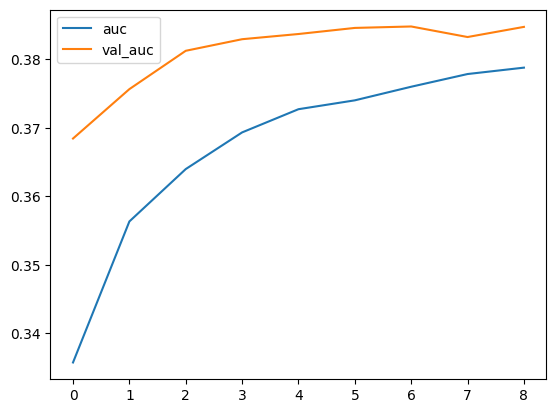

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

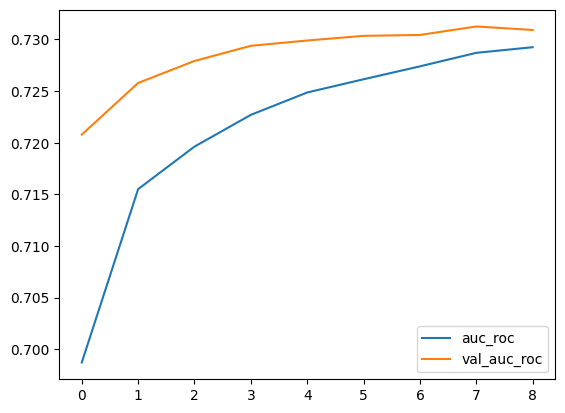

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('10_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [29]:
all_predictions = this_model.predict([X[features_numeric], X[features_naics]])

   81/21735 [..............................] - ETA: 41s

2024-05-19 13:17:32.282387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 44s 2ms/step


In [30]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [31]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.319903
target,0.319903,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [32]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [33]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [34]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.453762
11,0.22,0.452237
9,0.18,0.451952


In [35]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [36]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [37]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.557699
1    0.442301
Name: proportion, dtype: float64

In [38]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('10_DATA_predictions.parquet'))

## Metrics

In [39]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('10_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.609299,0.437891,0.308466,0.754438,0.361230,0.717226,NaN
1,train,0.655758,0.453762,0.334147,0.706759,0.389376,0.734882,NaN
2,val,0.654042,0.452355,0.333920,0.700980,0.384876,0.730951,NaN
0,test,0.652406,0.448357,0.330866,0.695236,0.378482,0.726526,0.0
1,test,0.537649,0.424242,0.282138,0.854761,0.349626,0.718901,1.0
